In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io

with open('dataset/axis.txt') as file:
    lines = [line.rstrip() for line in file]
wavenumbers = [float(wave) for wave in lines if wave != '']

Input_TrainData = scipy.io.loadmat('dataset/Train_Inputs.mat')['Train_Inputs']
Output_GT_TrainData = scipy.io.loadmat('dataset/Train_Outputs.mat')['Train_Outputs']
Input_TestData = scipy.io.loadmat('dataset/Test_Inputs.mat')['Test_Inputs']
Output_GT_TestData = scipy.io.loadmat('dataset/Test_Outputs.mat')['Test_Outputs']

In [2]:
np.save('./dataset/original_npy/Train_Inputs.npy', Input_TrainData)
np.save('./dataset/original_npy/Train_Outputs.npy', Output_GT_TrainData)
np.save('./dataset/original_npy/Test_Inputs.npy', Input_TestData)
np.save('./dataset/original_npy/Test_Outputs.npy', Output_GT_TestData)

In [2]:
from BaselineRemoval import BaselineRemoval
# baseline correction
def baseline_correlation_data(data_path, output_path):
    baseline_data = np.load(data_path, allow_pickle=True)
    # We add a small constant so we can apply a baseline correction to test spectra that have 
    # already been baseline corrected. 
    # baseline_data = Data
    baseline_data[np.where(baseline_data == 0)] = 0.0001

    for i in range(np.shape(baseline_data)[0]):
        baseObj = BaselineRemoval(baseline_data[i])
        Modpoly_output = baseObj.ModPoly(3)
        baseline_data[i] = Modpoly_output / np.max(Modpoly_output)
    
    np.save(output_path, baseline_data)

In [3]:
baseline_correlation_data('./dataset/original_npy/Train_Inputs.npy', './dataset/baseline_npy/Train_baselinInputs.npy')
baseline_correlation_data('./dataset/original_npy/Train_Outputs.npy', './dataset/baseline_npy/Train_baselinOutputs.npy')
baseline_correlation_data('./dataset/original_npy/Test_Inputs.npy', './dataset/baseline_npy/Test_baselinInputs.npy')
baseline_correlation_data('./dataset/original_npy/Test_Outputs.npy', './dataset/baseline_npy/Test_baselinOutputs.npy')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

with open('dataset/axis.txt') as file:
    lines = [line.rstrip() for line in file]
wavenumbers = [float(wave) for wave in lines if wave != '']
Input_TrainData = np.load('dataset/baseline_npy/Train_baselinInputs.npy')
Output_GT_TrainData = np.load('dataset/baseline_npy/Train_baselinOutputs.npy')
SMAE_pred = np.load('denoising_param/denoising_npy/SMAE_denoised.npy')

In [16]:
snr_total = []
N = 500
for i in range(Input_TrainData.shape[0]):
    x, y = Input_TrainData[i], Output_GT_TrainData[i]

    noise_power = (1 / N) * np.sum(np.square(x))
    signal_power = (1 / N) * np.sum(np.square(x - y))

    snr = 10 * np.log10(noise_power / signal_power)

    snr_total.append(snr)


np.mean(snr_total)

/tmp/ipykernel_1104906/1009884785.py:9: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(noise_power / signal_power)


-inf

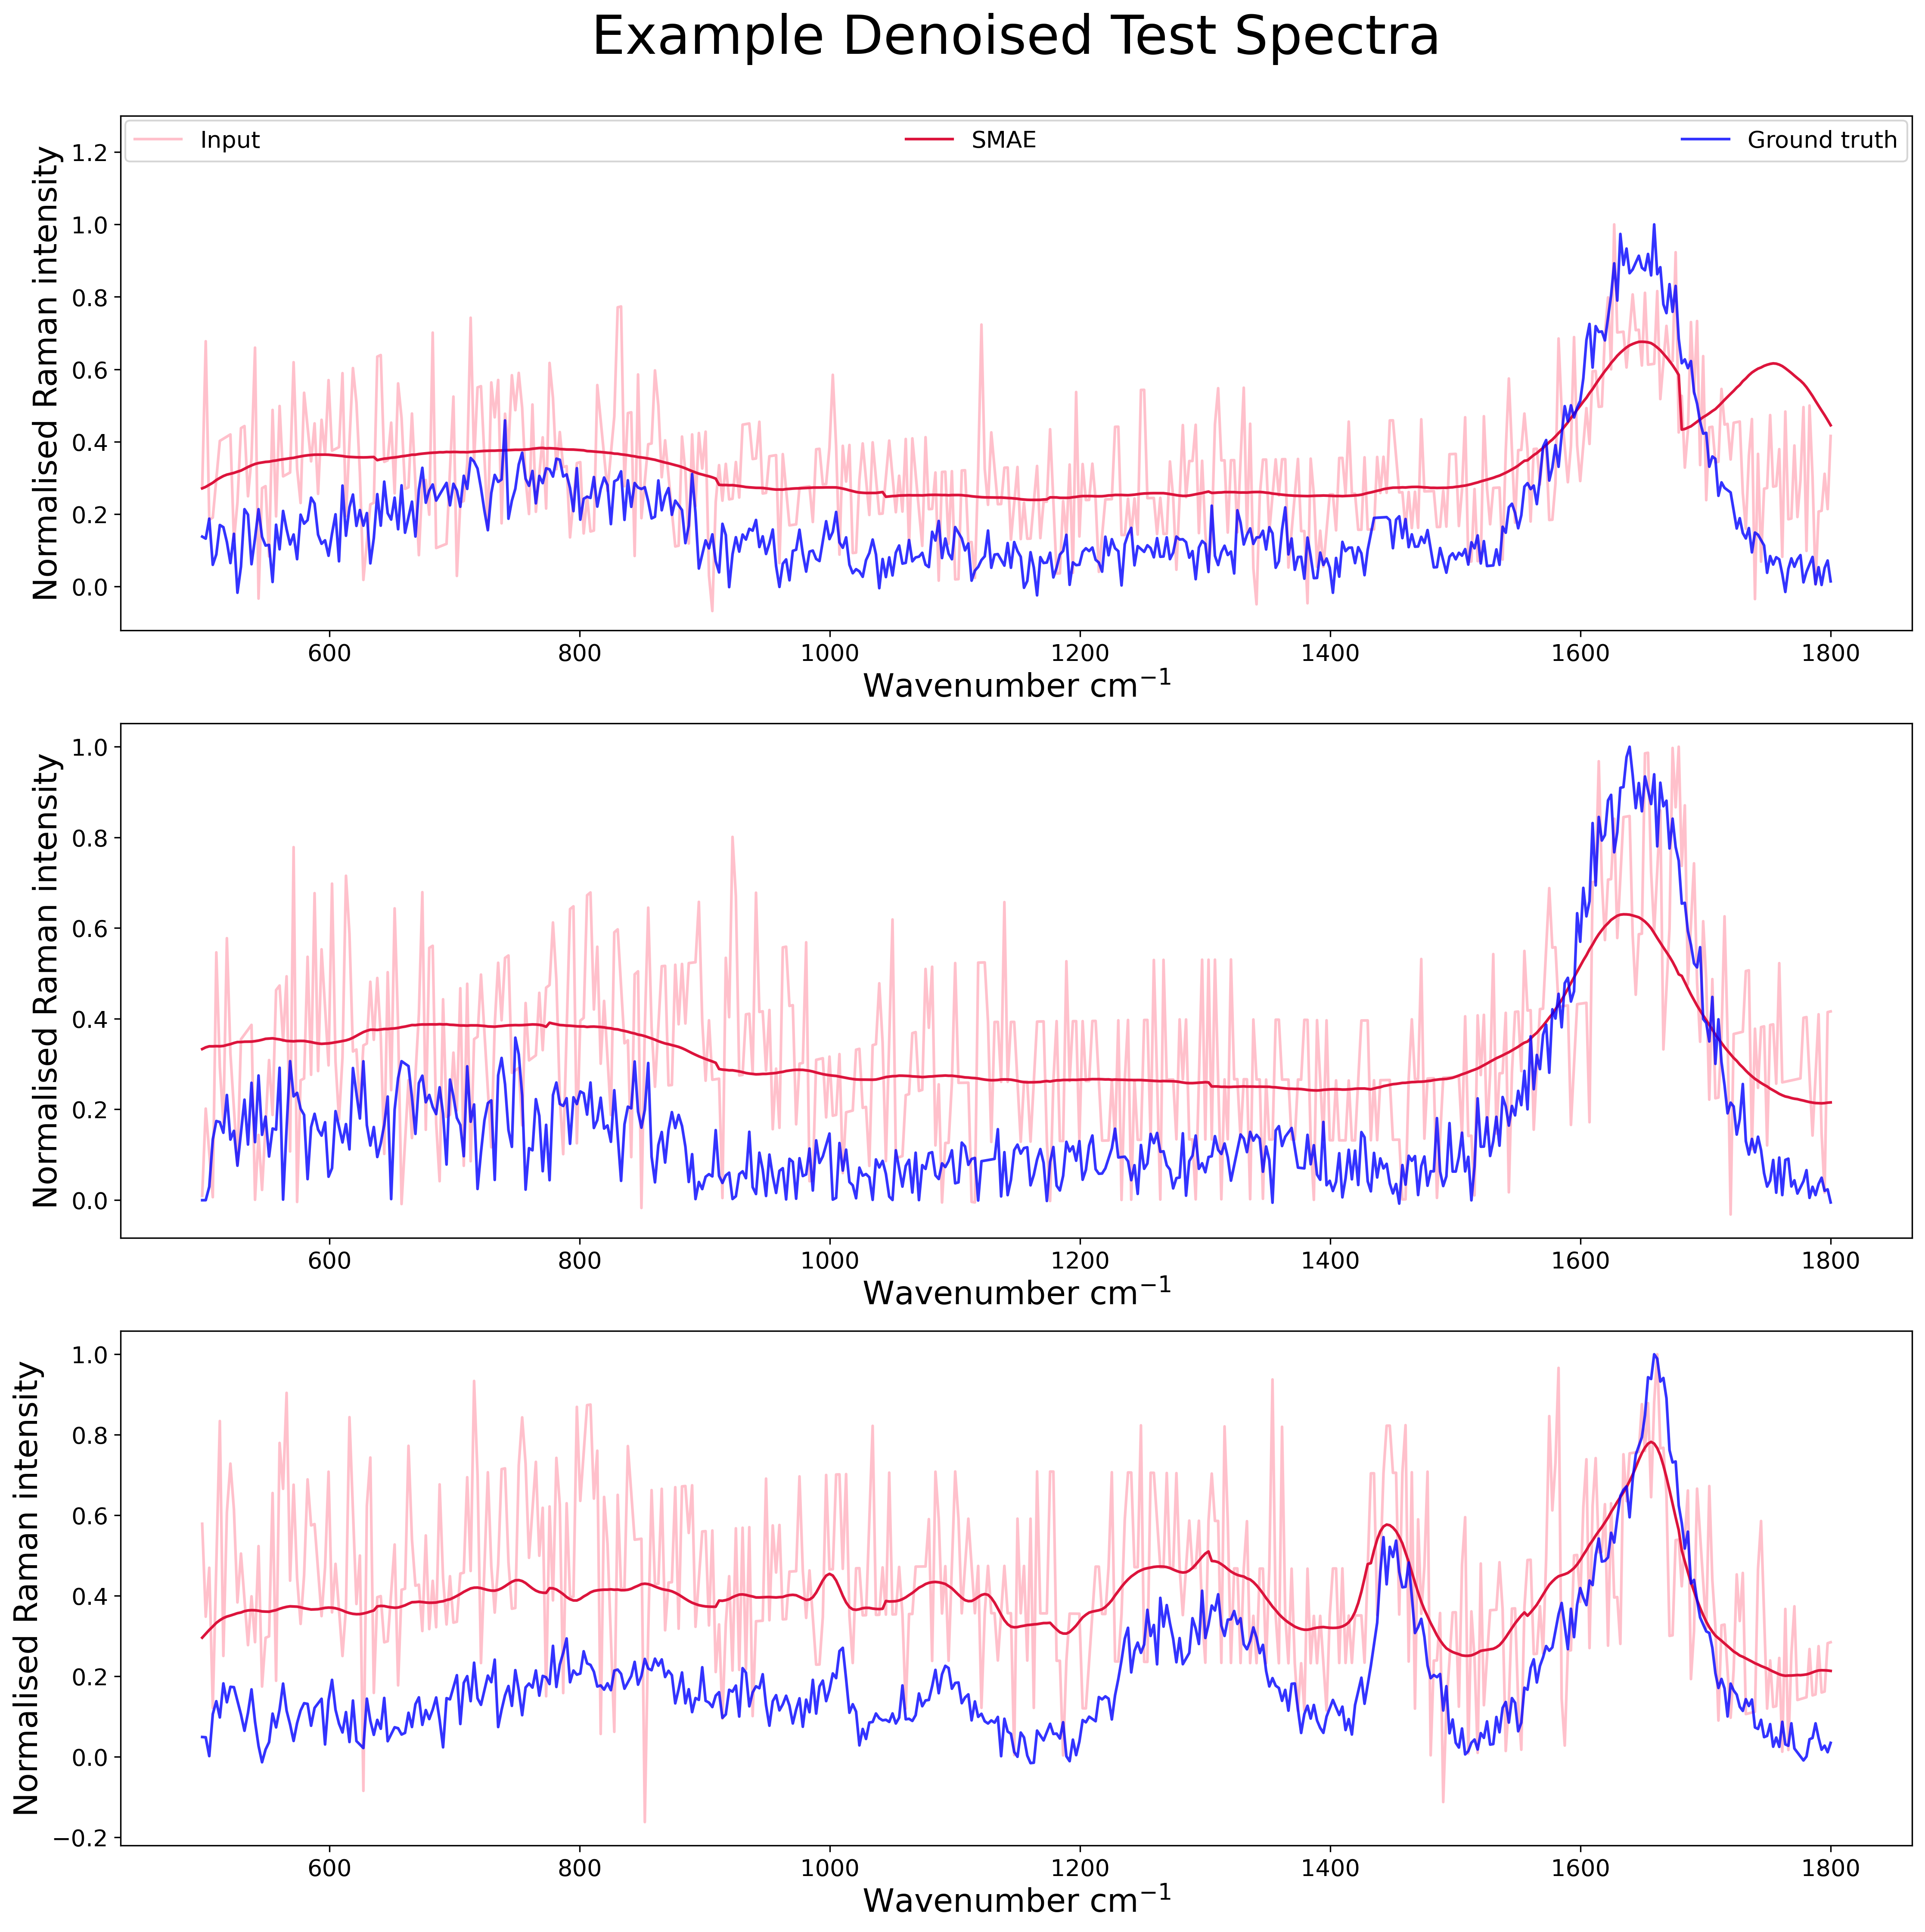

In [3]:
# plot example spectra for all techniques, using parameterisations derived from MCSE
example_inds=[4775,10000,22] #6699

plot_num = len(example_inds)
fig, ax = plt.subplots(plot_num, figsize=(15, 15), dpi=300)
for i in range(plot_num):
    index = example_inds[i]
    ax[i].plot(wavenumbers, np.squeeze(Input_TrainData[index]), label='Input', color='pink')
    ax[i].plot(wavenumbers, np.squeeze(SMAE_pred[index]), label='SMAE', color='crimson')
    ax[i].plot(wavenumbers, np.squeeze(Output_GT_TrainData[index]), label='Ground truth', alpha=0.8, color='blue')
    ax[i].set_ylabel('Normalised Raman intensity', fontsize = 18)
    ax[i].set_xlabel('Wavenumber cm$^{-1}$', fontsize = 18)
    ax[i].tick_params(axis='both', which='major', labelsize=13)
    if i == 0:
        ax[i].legend(loc='upper left',ncols=7, mode="expand", borderaxespad=0.2, fontsize = 13)
        ax[i].set_ylim(top=1.3)
ax[0].set_title('Example Denoised Test Spectra', fontsize = 30, y=1.1)
fig.tight_layout()